In [19]:
#This is the Importation Cell

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import gzip
import sys
import pickle
import time


f = gzip.open("C:\\Users\\ashle\\Classes\\IST597\\Midterm\\Data\\mnist.pkl.gz", 'rb')
if sys.version_info < (3,):
    data = pickle.load(f)
else:
    data = pickle.load(f, encoding='bytes')
f.close()
(x_train, labels), (x_test, _) = data
x_train = np.reshape(x_train, (60000,784))

In [260]:
#This is the cell that holds constants

amount = 100

max_iter = 100

max_iter_optim = 1000

target_perplexity = 30

LB = .01
UB = 10000

tolerance = .07

tol_optim = .002

eta = 15

check = 10

alpha = .8

sub_size = 50

# Functional Cells

#### Basic t-SNE Cell

In [138]:
#This is the cell that holds the basic t-SNE functions    

def get_p_j_given_i(X , SIGMA, i):

    n = X.shape[0]

    p_j_given_i = np.zeros((n))

    denominator = 0    

    for k in range(0,i):
        
        denominator += np.exp(-dist(X[i,:] , X[k,:]) / (2*(SIGMA[i]**2)))

    for k in range(i+1,n):
        
        denominator += np.exp(-dist(X[i,:] , X[k,:]) / (2*(SIGMA[i]**2)))

    for j in range(n):

        p_j_given_i[j] = np.exp(-dist(X[i,:] , X[j,:]) / (2*(SIGMA[i]**2))) / denominator



    return p_j_given_i


def get_p_ij(p_j_given_i_total):

    n = p_j_given_i_total.shape[0]

    p_ij = np.zeros_like(p_j_given_i_total)

    for i in range(n):

        for j in range(n):

            p_ij[i,j] = (p_j_given_i_total[i,j] + p_j_given_i_total[j,i])/(2*n)

    return p_ij


def get_q_ij(Y):

    n = Y.shape[0]

    denominator = 0

    q_ij = np.zeros((n,n))

    for k in range(n):

        for l in range(0,k):

            denominator += 1/(1+np.linalg.norm(Y[k,:] - Y[l,:])**2)

        for l in range(k+1,n):

            denominator += 1/(1+np.linalg.norm(Y[k,:] - Y[l,:])**2)

    for i in range(n):

        for j in range(n):

            q_ij[i,j] = (1/(1+np.linalg.norm(Y[i,:] - Y[j,:])**2)) / denominator


    return q_ij


def get_perplexity(p_j_given_i , i):

    n = p_j_given_i.shape[0]

    shannon_entropy = 0

    for j in range(i):

        shannon_entropy -= p_j_given_i[j]*np.log2(p_j_given_i[j])

    for j in range(i+1 , n):

        shannon_entropy -= p_j_given_i[j]*np.log2(p_j_given_i[j])

    return 2**(shannon_entropy)


def optimize_SIGMA(X , SIGMA):

    n = SIGMA.shape[0]

    for i in range(n):

        LB_i = LB
        UB_i = UB

        for k in range(max_iter):

            SIGMA[i] = (LB_i+UB_i)/2

            p_j_given_i = get_p_j_given_i(X , SIGMA , i)

            current_perplexity = get_perplexity(p_j_given_i , i)

            if(current_perplexity<target_perplexity):
                LB_i = SIGMA[i]
            else:
                UB_i = SIGMA[i]

            if np.abs((target_perplexity - current_perplexity)/target_perplexity)<tolerance:
                break

    return SIGMA


def get_KL_divergence(p_ij , q_ij):

    n = p_ij.shape[0]

    KL_divergence = 0;

    for i in range(n):

        for j in range(n):

            KL_divergence += p_ij[i,j]*np.log(p_ij[i,j] / q_ij[i,j])

    return KL_divergence


def get_dC_dy(Y , p_ij , q_ij):

    n = Y.shape[0]

    dC_dy = np.zeros_like(Y)

    for i in range(n):

        for j in range(0,i):

            dC_dy[i] += (p_ij[i,j] - q_ij[i,j])*(Y[i,:] - Y[j,:])/(1+np.linalg.norm(Y[i,:] - Y[j,:])**2)

        for j in range(i+1,n):

            dC_dy[i] += (p_ij[i,j] - q_ij[i,j])*(Y[i,:] - Y[j,:])/(1+np.linalg.norm(Y[i,:] - Y[j,:])**2)

        dC_dy[i] = dC_dy[i]*4

    return dC_dy


def update_Y(dC_dy , Y , Y_past):

    Y = Y - eta*dC_dy + alpha*(Y - Y_past)

    return Y

In [22]:
#This is the cell that holds the chosen distance function

def dist(x_i , x_j):
    
    return np.square(np.linalg.norm(x_i - x_j))

#### t-SNE Main Cell

In [256]:
#This cell holds the main function for t_SNE

def main_t_SNE(do_show):

    X = x_train.copy()[0:amount,:]
    
    N = X.shape[0]
    
    cost_past = 0

    end_iter = 0

    cost_array = np.zeros((max_iter_optim))

    SIGMA = np.zeros((N))

    SIGMA = optimize_SIGMA(X , SIGMA)

    Y = np.random.rand(N,2)

    col = []
    picker = list(['blue' , 'red' , 'yellow' , 'orange' , 'green' , 'magenta' , 'black' , 'pink' , 'purple' , 'cyan'])

    for i in range(N):

        col.append(picker[labels[i]])
            
    #for i in range(N):
     #   plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
    #plt.show()

    for i in range(max_iter_optim): 

        p_j_given_i_total = np.zeros((N,N))
    
        for k in range(N):
    
            p_j_given_i = get_p_j_given_i(X , SIGMA , k)
    
            p_j_given_i_total[k,:] = p_j_given_i
    
        p_ij = get_p_ij(p_j_given_i_total)
    
        q_ij = get_q_ij(Y)

        Y_past = Y.copy()

        #KL_divergence = get_KL_divergence(p_ij , q_ij)

        #print(KL_divergence)

        #cost_array[i] = KL_divergence

        dC_dy = get_dC_dy(Y , p_ij , q_ij)

        Y = update_Y(dC_dy , Y , Y_past)

        #for i in range(N):
         #   plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
        #plt.show()

        #if(i> 10 and (np.abs((cost_array[i] - cost_array[i-1])/cost_array[i-1]) < tol_optim)):
         #   print(i)
          #  end_iter = i
           # break

        #if(i> 10 and (np.linalg.norm(Y - Y_past)/np.linalg.norm(Y_past) < tol_optim)):
         #   print(i)
          #  end_iter = i
           # break

        if((i%check ==0)):
        
            cost = get_KL_divergence(p_ij , q_ij)

            #print(np.abs(cost - cost_past)/cost_past)

            if((np.abs(cost - cost_past)/cost_past <tol_optim )and (i>check)):
                print(i)
                end_iter = i
                break

            cost_past = cost

    if(do_show):
        for i in range(N):
            plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
        plt.show()

    #plt.plot(cost_array[:end_iter])
    #plt.show()

    return cost_array , Y , col , end_iter



#### Modified t-SNE Main Cell

In [ ]:
#The way that the modified method works (seen below) is just by breaking the dataset (in this case a subset of the MNIST dataset)
#into smaller, evenly sized chunks (in this case of size 50). The embeddings of the data points in each chunk are updated by performing a t-SNE 
#update on the chunk. The data is then grouped into different chunks and everything is repeated.

#This should make the time per iteration linear with N (assuming a constant group size), but I would think convergence will take
#longer. 

#If we assume N^2 is the complexity of a t-SNE iteration, the complexity of the modified version should be
#(N/50)*(50^2) or 50N.

In [257]:
#This cell holds the main function for t_SNE_mod (my improvement)

def shuffle(X , Y , Y_past , SIGMA , index , col):

    np.random.shuffle(index)

    X = X[index,:]
    Y = Y[index,:]
    Y_past = Y_past[index,:]
    SIGMA = SIGMA[index]

    col = col[index]

    return X , Y, Y_past , SIGMA , index , col


def update(Y , X , layers , top_num , Y_past , SIGMA , sub_size):

    N = X.shape[0]
    cost = 0

    count = int(np.floor(N/sub_size))


    for m in range(count):

        


        X_low = X[m*sub_size:(m+1)*sub_size,:]
        Y_low = Y[m*sub_size:(m+1)*sub_size,:]
        SIGMA_low = SIGMA[m*sub_size:(m+1)*sub_size]
        Y_past_low = Y_past[m*sub_size:(m+1)*sub_size,:]

        p_j_given_i_total = np.zeros((sub_size,sub_size))
        
        for k in range(sub_size):
    
            p_j_given_i = get_p_j_given_i(X_low , SIGMA_low , k)
    
            p_j_given_i_total[k,:] = p_j_given_i
    
        p_ij = get_p_ij(p_j_given_i_total)
    
        q_ij = get_q_ij(Y_low)

        

        #KL_divergence = get_KL_divergence(p_ij , q_ij)

        #cost += KL_divergence
            
    
        dC_dy = get_dC_dy(Y_low , p_ij , q_ij)

        Y_past_low_2 = Y_low.copy()
    
        Y_low = update_Y(dC_dy , Y_low , Y_past_low)

        Y[m*sub_size:(m+1)*sub_size,:] = Y_low

    
    
    return Y , cost

def main_t_SNE_mod(do_show):

    X = x_train.copy()[0:amount,:]
    
    N = X.shape[0]

    cost_past = 0
    end_iter = 0

    index = np.arange(N)

    cost_array = np.zeros((max_iter_optim))

    SIGMA = np.zeros((N))

    SIGMA = optimize_SIGMA(X , SIGMA)

    Y = np.random.rand(N,2)

    col = []
    picker = list(['blue' , 'red' , 'yellow' , 'orange' , 'green' , 'magenta' , 'black' , 'pink' , 'purple' , 'cyan'])

    for i in range(N):

        col.append(picker[labels[i]])

    col = np.array(col)
            
    #for i in range(N):
     #   plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
    #plt.show()

    test = N
    layers = 0
    while test%1 == 0:
        test/=2
        layers +=1
    top_num = 2*test
    layers -=1  
    if(top_num == 1):
        top_num = 2
        layers -=1
        

    for i in range(max_iter_optim): 

        Y_past = Y.copy()


        X , Y , Y_past , SIGMA , index ,col = shuffle(X , Y , Y_past , SIGMA , index , col)


        Y , cost = update(Y , X , layers , top_num , Y_past , SIGMA , sub_size)

        #for i in range(N):
         #   plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
        #plt.show()

        cost_array[i] = cost

        #if(i> 10 and (np.abs((cost_array[i] - cost_array[i-1])/cost_array[i-1]) < tol_optim)):
         #   print(i)
          #  end_iter = i
           # break

        #if(i> 10 and (np.linalg.norm(Y - Y_past)/np.linalg.norm(Y_past) < tol_optim)):
         #   print(i)
          #  end_iter = i
           # break

        if(True == False):#(i%check ==0)): I have this turned off so I can run the very last test of my version. All others were done with it on.
            p_j_given_i_total = np.zeros((N,N))
    
            for k in range(N):
        
                p_j_given_i = get_p_j_given_i(X , SIGMA , k)
        
                p_j_given_i_total[k,:] = p_j_given_i
        
            p_ij = get_p_ij(p_j_given_i_total)
        
            q_ij = get_q_ij(Y)
    
            Y_past = Y.copy()
    
            cost = get_KL_divergence(p_ij , q_ij)

            if((np.abs(cost - cost_past)/cost_past <tol_optim) and (i>check)):
                print(i)
                end_iter = i
                break

            cost_past = cost

    if(do_show):
        for i in range(N):
            plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
        plt.show()

    #plt.plot(cost_array)
    #plt.show()

    return cost_array , Y , col , index , X , end_iter



# Analysis Cells

#### Showcase of t-SNE

In [270]:
#This cell performs a t-SNE analysis of 600 of the MNIST images, which is all I could manage because
#my implementation is so slow. :( The following cell is seperate so I can mess with the visualization stuff.
#My convergence specifications are seemingly quite poor, as the larger the N, the shorter the time to convergence for some reason.
#I'm pretty sure this is because the changes in the cost are low enough per iteration that it mimics being converged at a low
#number of iterations. I cant really solve this, so I am just going to run this one for 300 iterations, which seems to be enough.
#The code is slow enough I do not have the luxury of experimenting.

amount = 600
tol_optim = 0
max_iter_optim = 300

t1 = time.time()
cost_array , Y , col , _ = main_t_SNE(False)
t2 = time.time()
dt_og = t2 - t1

tol_optim = .002
max_iter_optim = 1000

print(dt_og)


C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\3765700741.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim )and (i>check)):


5998.5550746917725


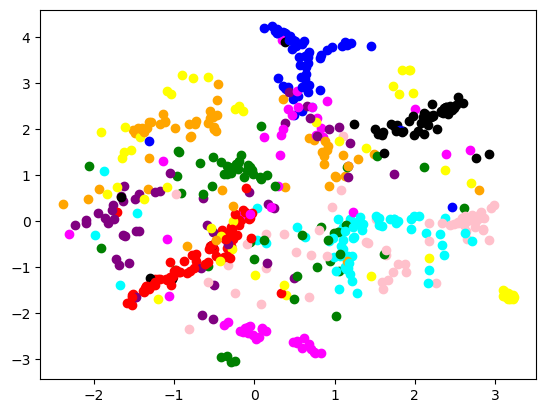

In [271]:
#As you can see this took an hour and 40 minutes and it really isn't converged at this point, although it has done a reasonable
#amount of grouping
N = 600
for i in range(N):
    plt.scatter(Y[i,0] , Y[i,1] , color = col[i])
plt.show()

In [317]:
#This time I'll do the analysis on 100 images, with 1000 iterations to see if the seperation is better.

amount = 100
tol_optim = 0
max_iter_optim = 1000

t1 = time.time()
cost_array , Y , col , _ = main_t_SNE(False)
t2 = time.time()
dt_og = t2 - t1

tol_optim = .002
max_iter_optim = 1000

print(dt_og)


C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\3765700741.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim )and (i>check)):


532.9076669216156


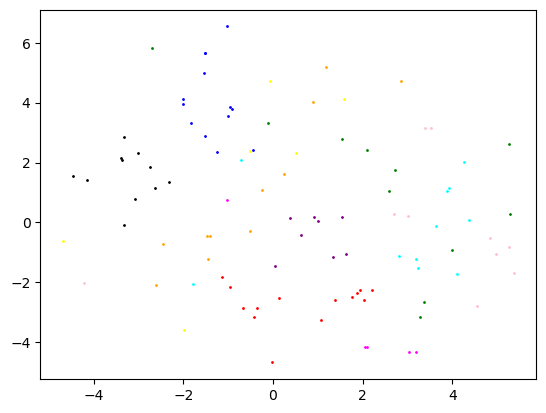

In [318]:
#This one took 9 minutes to run and is much better separated. There are some colors, corresponding to numbers,
#that are much more intermingled than others. For example, Cyan, Pink, and Green, corresponding to 9, 7, and 4
#are very intermingled. This makes sense, as 9 and 4 are very similar and 7 is also fairly close to the other two.
#We also see yellow and orange (3 and 2) being close to one another, which makes sense as the top curl is similar.
#I'm not sure what would make these less likely to intermingle. I have varied the parameters, but this is what I get.

N = 100
for i in range(N):
    plt.scatter(Y[i,0] , Y[i,1] , color = col[i] , s = 1)
plt.show()

#### Showcase of Modified t-SNE

In [319]:
#This time I'll do the same analysis as above, but with the modified version.

amount = 100
tol_optim = 0
max_iter_optim = 1000

t1 = time.time()
cost_array , Y , col , index , X , _ = main_t_SNE_mod(False)
t2 = time.time()
dt_og = t2 - t1

tol_optim = .002
max_iter_optim = 1000

print(dt_og)


C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\2949124707.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim) and (i>check)):


307.17230772972107


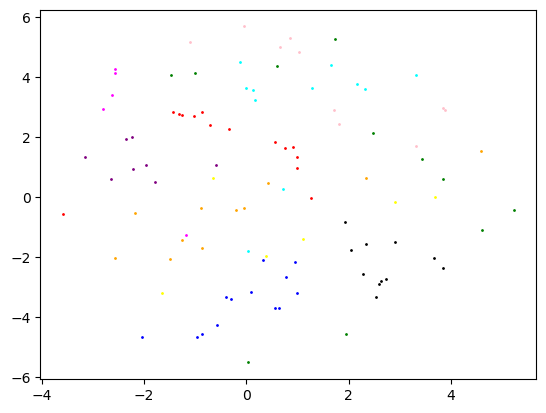

In [320]:
#This one took only 5.1 minutes to complete, which is almost half of the normal version. Given that my group size is 50
#and N is 100, this makes sense. Original = N^2 , New = (N/50)*(50^2) = 50N. This is 10,000 vs 5,000 for N = 100
#It has pretty much the same issues as the unmodified version as far as grouping goes. This may be due to the distance
#function I chose being Euclidian, which is not suited for high dimensional space.

N = 100
for i in range(N):
    plt.scatter(Y[i,0] , Y[i,1] , color = col[i] , s = 1)
plt.show()

#### Convergence Analysis

In [ ]:
#The couple cells below do some quick tests with my convergence criterion to see time to convergence with them.

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\3765700741.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim )and (i>check)):


130


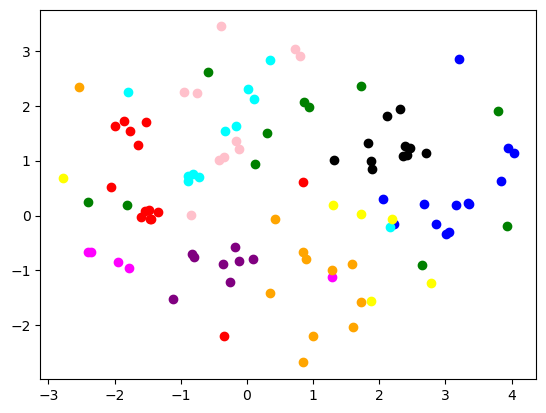

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\2949124707.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim) and (i>check)):


110


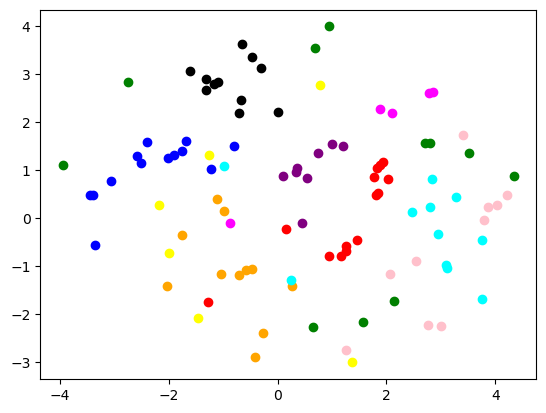

74.21454668045044
38.25994920730591


In [262]:
#This cell just does some visualization stuff, along with the following one

amount = 100


t1 = time.time()
cost_array , Y , col , _ = main_t_SNE(True)
t2 = time.time()
dt_og = t2 - t1

t1 = time.time()
cost_array , Y , col , index , X , _ = main_t_SNE_mod(True)
t2 = time.time()
dt_new = t2 - t1

print(dt_og)
print(dt_new)

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\3765700741.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim )and (i>check)):


120


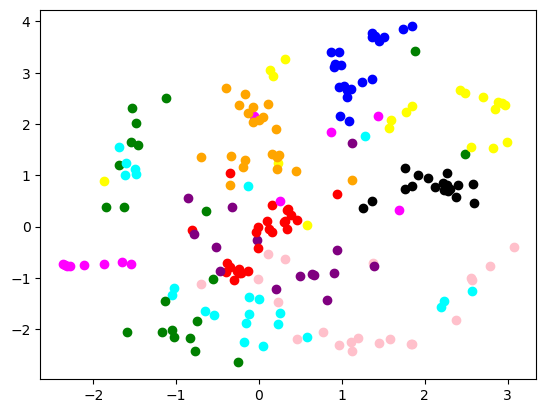

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\2949124707.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim) and (i>check)):


90


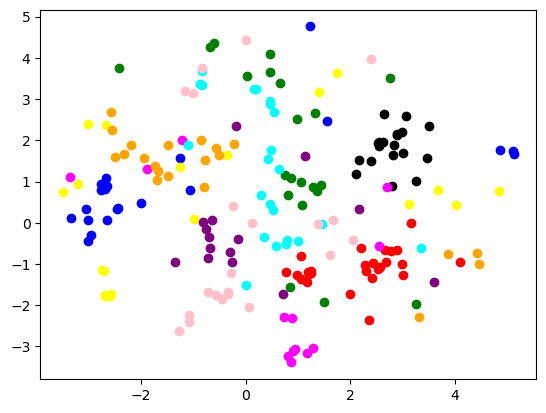

275.4111416339874
77.76706528663635


In [263]:
#This cell just does some visualization stuff

amount = 200

t1 = time.time()
cost_array , Y , col , _ = main_t_SNE(True)
t2 = time.time()
dt_og = t2 - t1

t1 = time.time()
cost_array , Y , col , index , X , _ = main_t_SNE_mod(True)
t2 = time.time()
dt_new = t2 - t1

print(dt_og)
print(dt_new)

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\3765700741.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim )and (i>check)):


100


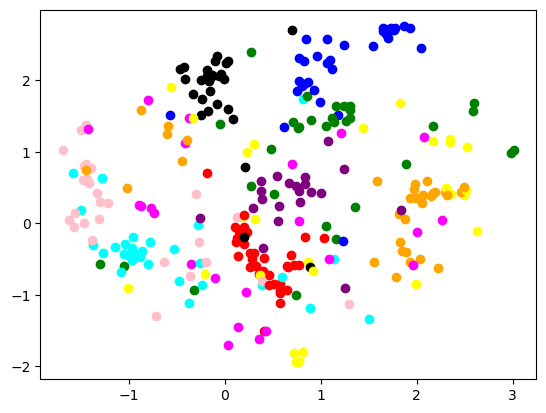

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\2949124707.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim) and (i>check)):


80


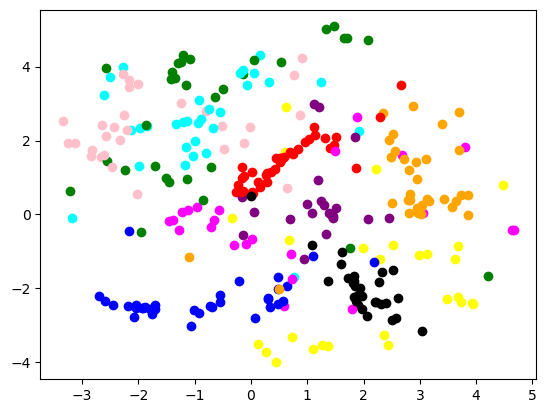

529.1778337955475
127.44564199447632


In [264]:
#This cell just does some visualization stuff

amount = 300

t1 = time.time()
cost_array , Y , col , _ = main_t_SNE(True)
t2 = time.time()
dt_og = t2 - t1

t1 = time.time()
cost_array , Y , col , index , X , _ = main_t_SNE_mod(True)
t2 = time.time()
dt_new = t2 - t1

print(dt_og)
print(dt_new)

In [ ]:
#These three runs showcase some of the time to convergence qualities of each method.
#The first printed number after both plots is the time of the original method and the second is the time of the new method.
#The first plot under each cell is the unmodified and the second is the modified. 

#For both methods, I checked for convergence every 10 iterations, and convergence was defined as the percent difference
#in the cost being lower than .2%. As you can see, the iterations to convergence (seen above each plot) decreases with a higher N and none
#of the tests appear very well converged. This leads me to believe that the method of convergece I chose was pretty poor.
#I tested others, which can be seen in the code, but they also didn't really work. A lower threshhold also seemed
#to not really work, as there would be too much noise, or the method wouldn't converge. Given this, the following results
#are somewhat inconclusive.

#Times of the original method were (100 , 1.23) , (200 , 4.58) , (300 , 9.33) in the form (N , time in minutes).
#This is fit by the formula T = .00007N^2 + .0125N - .72, , which is not going to be exact for other N values.
#That formula estimates a time for the entire MNIST dataset as ~175 days. This is probably due to the implementation 
#being in python and having been coded by me, who is not the most efficient programmer.
#This also explains why I chose not to run the entire dataset.
#The linear regression approximation of these 3 values has an adjusted R^2 of .98028

#Times of the new method were (100 , .63) , (200 , 1.296) , (300 , 2.124) in the form (N , time in minutes).
#This is fit by the formula T = .0000081N^2 + .00423N + .126, which is not going to be exact for other N values.
#It is also close to the linear function .00747N - .144 with an adjusted R^2 of .992192
#The parabolic function estimates 20 days for the entire dataset, while the linear estimates
#around 7.5 hours.

#### Time vs N for the Modified Version

In [294]:
#This cell runs tests of the modified version vs N, in increments of 50
#Each test is done for 1000 iterations with no convergence criterion.

time_list = []
Y_list = []
index_list = []
col_list = []
X_list = []

for place in range(20):

    amount = 50 + 50*place
    tol_optim = 0
    max_iter_optim = 1000
    
    t1 = time.time()
    cost_array , Y , col , index , X , _ = main_t_SNE_mod(False)
    t2 = time.time()
    dt_og = t2 - t1
    
    tol_optim = .002
    max_iter_optim = 1000

    time_list.append(dt_og)
    Y_list.append(Y.copy())
    X_list.append(X.copy())
    index_list.append(index.copy())
    col_list.append(col.copy())

C:\Users\ashle\AppData\Local\Temp\ipykernel_3128\2949124707.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  if((np.abs(cost - cost_past)/cost_past <tol_optim) and (i>check)):


KeyboardInterrupt: 

(800, 2)


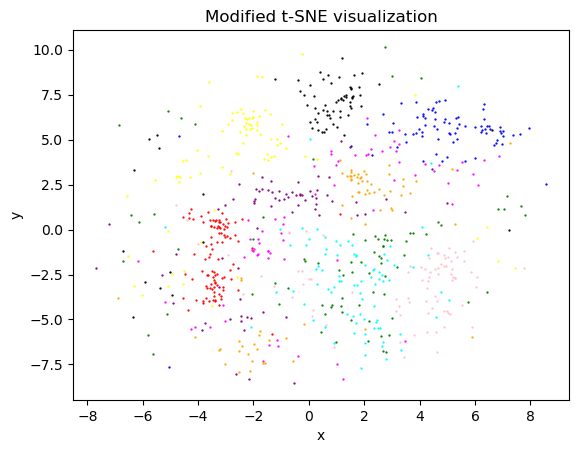

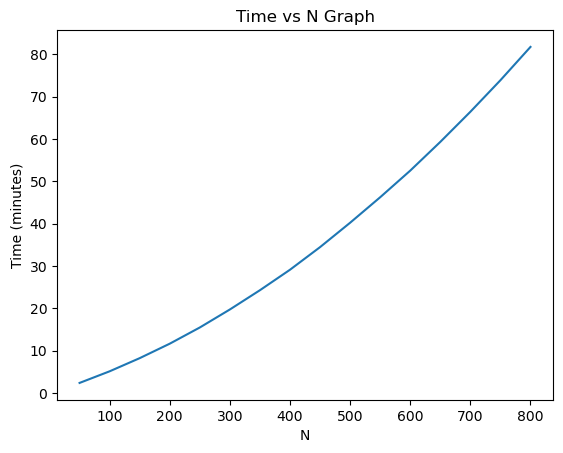

In [321]:
#I had to stop the above early (at 16 rather than 20 tests) because it took all night.
#This cell's results show the 800 = N run (the largest that ran overnight) and 
#a time vs N graph below, both for the modified version

#Once again, the analysis is not perfect. Cyan and Green (9 and 4) are overlapping again, which is an issue with both methods. 
#This may be indicitave of lack of convergence or convergence to a local minima.

#The time vs N graph shows that the method is not perfectly linear as expected. I think this is due to the
#optimization of the sigmas that take place before every run, which is still an N^2 affair.

#Regardless, this modified version is much faster than the unmodified version. The unmodified version 
#took an hour and 40 minutes for N=600 and iterations = 300, whereas the modified version
#took only 50 minutes for N=600 and iterations = 1000. Time is linear with iteration amount,
#so we can estimate how long 1000 iterations of the unmodified version as ~ 5.5 hours. 
#This is a speed up of around 6.6 fold with the modified version, which is about half of what I would expect, as
#the modified version is essentially doing (N/50)*(50^2) or 50N, while the unmodified version does
#N^2, at 600 = N thats (600^2)/(50*600) = 600/50 = 12 or a 12x increase in speed. Its probably not right due to 
#overhead.

#Also, just to give another point to the modified version, the N=800 for 1000 iterations took only 
#an hour and 20 minutes as compared to the hour and 40 minutes for N=300 for 300 iterations of the 
#unmodified version.

#I didn't really give a statistical analysis of the improvements, but you can see there are definite improvements over
#the unmodified version. I would love to have been able to perform a better analysis, but I am 
#out of time and my other commitments beckon. Also, sorry things arent super well commented.

print(Y_list[15].shape)

N = 50+15*50
for i in range(N):
    plt.scatter(Y_list[15][i,0] , Y_list[15][i,1] , color = col_list[15][i] , s = .4)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Modified t-SNE visualization")
plt.show()

#for i in range(16): Ran multiple times so its already in minutes
 #   time_list[i] = time_list[i]*60
    
plt.plot(np.arange(0,16)*50 + 50, time_list)
plt.xlabel("N")
plt.ylabel("Time (minutes)")
plt.title("Time vs N Graph")
plt.show()